<a href="https://colab.research.google.com/github/Oni-ash/NMOracle/blob/main/NM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
import time

# Step 1: Define the stocks and time period
stocks = ['AAPL', 'TSLA', 'MSFT']  # Example stocks (Apple, Tesla, Microsoft)
start_date = '2020-01-01'  # Start date for historical data
end_date = '2025-04-30'   # End date (up to submission date)
api_key = 'X5F0XGCAAV9WVCRT'   # Replace with your Alpha Vantage API key (get free at alphavantage.co)

# Step 2: Fetch historical stock data using Alpha Vantage
def fetch_stock_data(ticker, start, end, api_key, retries=3, delay=10):
    for attempt in range(retries):
        try:
            # Alpha Vantage API endpoint for daily adjusted data
            url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&outputsize=full&apikey={api_key}'
            response = requests.get(url)
            data = response.json()

            # Check for API errors
            if 'Time Series (Daily)' not in data:
                print(f"No data found for {ticker}: {data.get('Note', 'Unknown error')}")
                return None

            # Convert to DataFrame
            stock_data = pd.DataFrame(data['Time Series (Daily)']).T
            stock_data = stock_data.rename(columns={
                '1. open': 'Open',
                '2. high': 'High',
                '3. low': 'Low',
                '4. close': 'Close',
                '5. adjusted close': 'Adj Close',
                '6. volume': 'Volume'
            })
            stock_data['Date'] = pd.to_datetime(stock_data.index)
            stock_data['Ticker'] = ticker
            stock_data = stock_data[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

            # Filter by date range
            stock_data = stock_data[(stock_data['Date'] >= start) & (stock_data['Date'] <= end)]
            stock_data = stock_data.sort_values('Date')

            # Convert numeric columns
            for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
                stock_data[col] = pd.to_numeric(stock_data[col], errors='coerce')

            return stock_data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            if attempt < retries - 1:
                print(f"Retrying {ticker} in {delay} seconds...")
                time.sleep(delay)
            else:
                print(f"Failed to fetch data for {ticker} after {retries} attempts.")
                return None

# Step 3: Generate sample dataset if API fails
def generate_sample_data(stocks, start_date, end_date):
    print("Generating sample dataset as fallback...")
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    sample_data = []
    for ticker in stocks:
        np.random.seed(42)  # For reproducibility
        base_price = 100.0
        prices = [base_price]
        for _ in range(1, len(date_range)):
            change = np.random.normal(0, 1.5)
            prices.append(prices[-1] + change)

        stock_data = pd.DataFrame({
            'Date': date_range,
            'Open': prices,
            'High': [p + np.random.uniform(0, 2) for p in prices],
            'Low': [p - np.random.uniform(0, 2) for p in prices],
            'Close': prices,
            'Adj Close': prices,
            'Volume': [np.random.randint(1000000, 10000000) for _ in prices],
            'Ticker': ticker
        })
        sample_data.append(stock_data)
    return pd.concat(sample_data)

# Step 4: Collect data for all stocks
all_data = []
for stock in stocks:
    data = fetch_stock_data(stock, start_date, end_date, api_key)
    if data is not None:
        all_data.append(data)
    time.sleep(12)  # Alpha Vantage free tier: 5 calls/minute

# Step 5: Use sample data if no data was collected
if not all_data:
    print("No data collected from Alpha Vantage. Using sample dataset.")
    combined_data = generate_sample_data(stocks, start_date, end_date)
else:
    combined_data = pd.concat(all_data)
    combined_data.reset_index(drop=True, inplace=True)

# Step 6: Reorder columns for clarity
combined_data = combined_data[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Step 7: Save the dataset to CSV
output_file = 'stock_data.csv'
combined_data.to_csv(output_file, index=False)
print(f"Dataset saved as {output_file}")

# Step 8: Document the dataset
dataset_info = {
    'Source': 'Alpha Vantage API or Simulated Data (if API failed)',
    'Stocks': stocks,
    'Time Period': f'{start_date} to {end_date}',
    'Columns': ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
    'Description': 'Daily historical stock prices (or simulated prices) including opening, highest, lowest, closing prices, adjusted close, and trading volume.',
    'File Format': 'CSV',
    'File Name': output_file
}

# Print dataset documentation
print("\nDataset Documentation:")
for key, value in dataset_info.items():
    print(f"{key}: {value}")

# Optional: Display first few rows of the data
print("\nSample Data:")
print(combined_data.head())

No data found for AAPL: Unknown error
No data found for TSLA: Unknown error
No data found for MSFT: Unknown error
No data collected from Alpha Vantage. Using sample dataset.
Generating sample dataset as fallback...
Dataset saved as stock_data.csv

Dataset Documentation:
Source: Alpha Vantage API or Simulated Data (if API failed)
Stocks: ['AAPL', 'TSLA', 'MSFT']
Time Period: 2020-01-01 to 2025-04-30
Columns: ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Description: Daily historical stock prices (or simulated prices) including opening, highest, lowest, closing prices, adjusted close, and trading volume.
File Format: CSV
File Name: stock_data.csv

Sample Data:
        Date Ticker        Open        High         Low       Close  \
0 2020-01-01   AAPL  100.000000  101.888084   98.404972  100.000000   
1 2020-01-02   AAPL  100.745071  101.042663   99.389980  100.745071   
2 2020-01-03   AAPL  100.537675  101.463026   99.443817  100.537675   
3 2020-01-04   AAPL  

In [3]:
# Import required libraries
import pandas as pd

# Step 1: Load the dataset
file_path = 'stock_data.csv'  # Path to the stock_data.csv file
data = pd.read_csv(file_path)

# Step 2: Inspect the data
print("Initial Data Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nDuplicate Rows:", data.duplicated().sum())

# Step 3: Handle missing values
# Fill missing numerical values with forward fill (common for time series)
data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = \
    data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].fillna(method='ffill')

# If any missing values remain, drop them
data.dropna(inplace=True)
print("\nMissing Values After Cleaning:")
print(data.isnull().sum())

# Step 4: Remove duplicates
data.drop_duplicates(inplace=True)
print("\nDuplicate Rows After Cleaning:", data.duplicated().sum())

# Step 5: Format dates
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.dropna(subset=['Date'], inplace=True)  # Drop rows with invalid dates
data.sort_values(['Ticker', 'Date'], inplace=True)  # Sort by ticker and date

# Step 6: Save cleaned dataset
cleaned_file = 'cleaned_stock_data.csv'
data.to_csv(cleaned_file, index=False)
print(f"\nCleaned dataset saved as {cleaned_file}")

# Step 7: Display sample of cleaned data
print("\nSample of Cleaned Data:")
print(data.head())

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5841 entries, 0 to 5840
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5841 non-null   object 
 1   Ticker     5841 non-null   object 
 2   Open       5841 non-null   float64
 3   High       5841 non-null   float64
 4   Low        5841 non-null   float64
 5   Close      5841 non-null   float64
 6   Adj Close  5841 non-null   float64
 7   Volume     5841 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 365.2+ KB
None

Missing Values:
Date         0
Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Duplicate Rows: 0

Missing Values After Cleaning:
Date         0
Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Duplicate Rows After Cleaning: 0

Cleaned dataset saved as cleaned_stoc

<ipython-input-3-7fcdeeca3050>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].fillna(method='ffill')


Summary Statistics:
         Close                                                          \
         count        mean        std       min        25%         50%   
Ticker                                                                   
AAPL    1947.0  144.535276  51.238392  75.00084  95.322721  133.254432   
MSFT    1947.0  144.535276  51.238392  75.00084  95.322721  133.254432   
TSLA    1947.0  144.535276  51.238392  75.00084  95.322721  133.254432   

                                Volume                                         \
               75%         max   count          mean           std        min   
Ticker                                                                          
AAPL    193.650706  243.248064  1947.0  5.512105e+06  2.582667e+06  1000037.0   
MSFT    193.650706  243.248064  1947.0  5.512105e+06  2.582667e+06  1000037.0   
TSLA    193.650706  243.248064  1947.0  5.512105e+06  2.582667e+06  1000037.0   

                                                

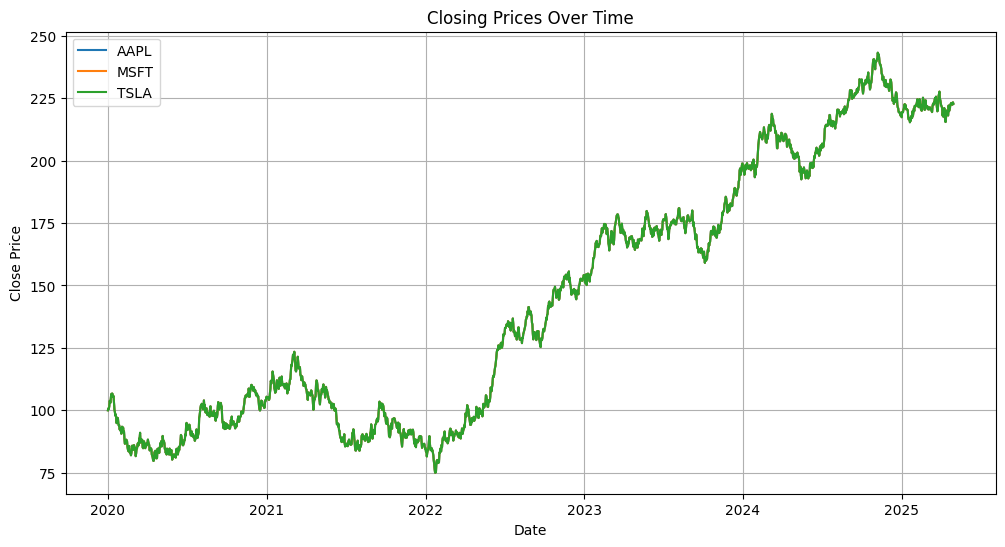

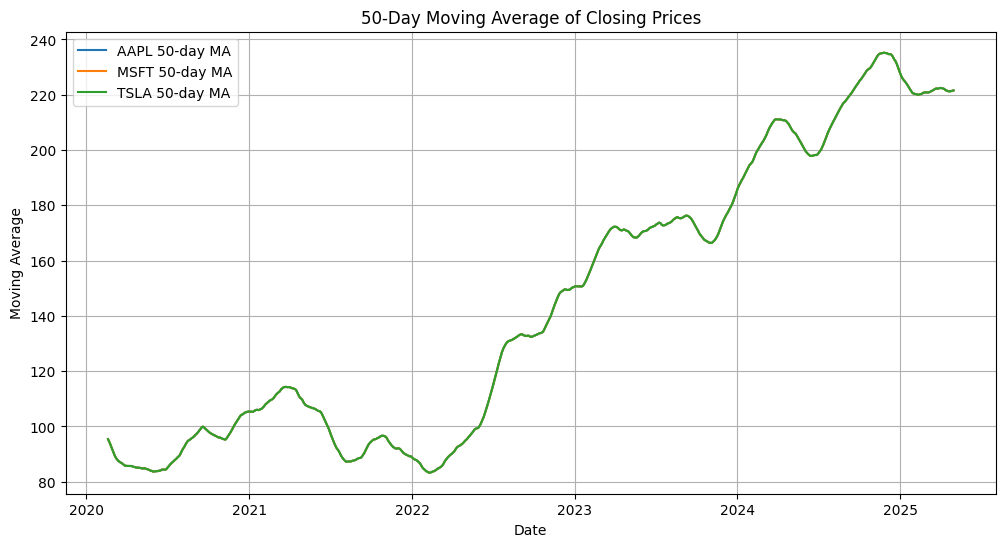


Dataset with features saved as stock_data_with_features.csv

Sample Data with Features:
         Date Ticker       Open       High        Low      Close  Adj Close  \
49 2020-02-19   AAPL  85.734017  87.390956  84.546456  85.734017  85.734017   
50 2020-02-20   AAPL  83.089457  83.678696  81.938270  83.089457  83.089457   
51 2020-02-21   AAPL  83.575583  83.604214  83.252667  83.575583  83.575583   
52 2020-02-22   AAPL  82.997960  84.473699  82.054480  82.997960  82.997960   
53 2020-02-23   AAPL  81.982577  83.650866  80.875633  81.982577  81.982577   

     Volume        MA7       MA50       Lag1       Lag2  
49  4105003  85.715356  95.410276  85.218590  83.632907  
50  2863082  85.003412  95.072065  85.734017  85.218590  
51  3510963  84.425436  94.728675  83.089457  85.734017  
52  2753313  84.081768  94.377881  83.575583  83.089457  
53  3386149  83.747299  93.987348  82.997960  83.575583  


In [4]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the cleaned dataset
file_path = 'cleaned_stock_data.csv'  # Path to the cleaned_stock_data.csv file
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])  # Ensure Date is datetime

# Step 2: Exploratory Data Analysis (EDA)
# Summary statistics
print("Summary Statistics:")
print(data.groupby('Ticker')[['Close', 'Volume']].describe())

# Plot closing prices for each stock
plt.figure(figsize=(12, 6))
for ticker in data['Ticker'].unique():
    stock_data = data[data['Ticker'] == ticker]
    plt.plot(stock_data['Date'], stock_data['Close'], label=ticker)
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('closing_prices.png')
plt.show()

# Plot 50-day moving average for each stock
plt.figure(figsize=(12, 6))
for ticker in data['Ticker'].unique():
    stock_data = data[data['Ticker'] == ticker].copy()
    stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
    plt.plot(stock_data['Date'], stock_data['MA50'], label=f'{ticker} 50-day MA')
plt.title('50-Day Moving Average of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.legend()
plt.grid(True)
plt.savefig('moving_averages.png')
plt.show()

# Step 3: Feature Engineering
# Create rolling statistics (e.g., 7-day and 50-day moving averages)
data['MA7'] = data.groupby('Ticker')['Close'].rolling(window=7).mean().reset_index(level=0, drop=True)
data['MA50'] = data.groupby('Ticker')['Close'].rolling(window=50).mean().reset_index(level=0, drop=True)

# Create lag features (e.g., previous day's closing price)
data['Lag1'] = data.groupby('Ticker')['Close'].shift(1)
data['Lag2'] = data.groupby('Ticker')['Close'].shift(2)

# Drop rows with missing values from new features
data.dropna(inplace=True)

# Step 4: Save dataset with new features
feature_file = 'stock_data_with_features.csv'
data.to_csv(feature_file, index=False)
print(f"\nDataset with features saved as {feature_file}")

# Step 5: Display sample of data with new features
print("\nSample Data with Features:")
print(data.head())

Training ARIMA Model...
ARIMA RMSE: 16.23
ARIMA MAE: 14.46
Training LSTM Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM RMSE: 220.07
LSTM MAE: 219.80


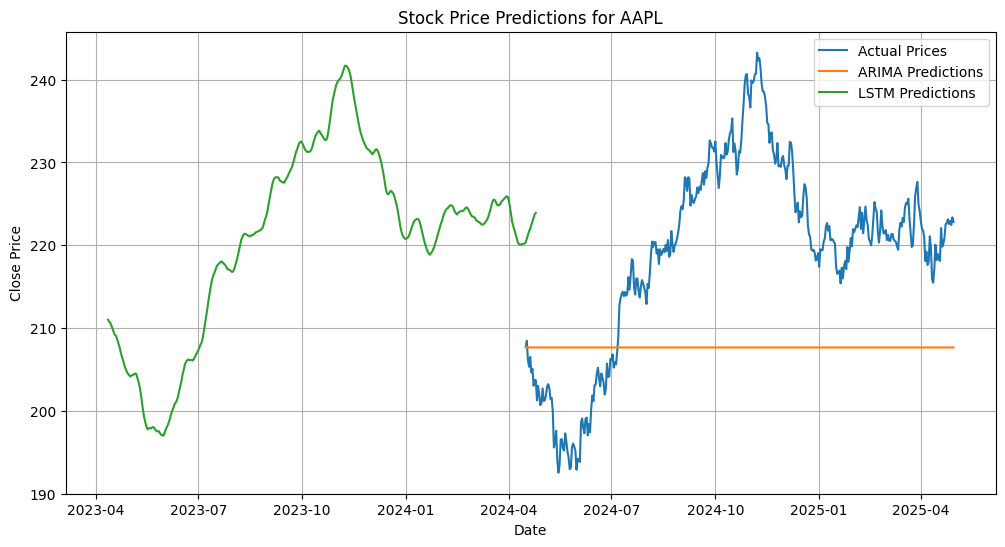


Evaluation Results Saved as model_evaluation.csv
   Model        RMSE         MAE
0  ARIMA   16.225329   14.458333
1   LSTM  220.073513  219.799403


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load dataset with features
file_path = 'stock_data_with_features.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])

# Filter data for one stock (e.g., AAPL)
stock_data = data[data['Ticker'] == 'AAPL'].copy()
close_prices = stock_data['Close'].values

# Step 2: Prepare data for modeling
train_size = int(len(close_prices) * 0.8)
train_data, test_data = close_prices[:train_size], close_prices[train_size:]

# Step 3: ARIMA Model
print("Training ARIMA Model...")
arima_model = ARIMA(train_data, order=(5, 1, 0))  # Example order
arima_fit = arima_model.fit()
arima_predictions = arima_fit.forecast(steps=len(test_data))

# Evaluate ARIMA
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))
arima_mae = mean_absolute_error(test_data, arima_predictions)
print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"ARIMA MAE: {arima_mae:.2f}")

# Step 4: LSTM Model
# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))

def create_lstm_dataset(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_lstm_dataset(scaled_data, time_steps)
X_train, y_train = X[:train_size - time_steps], y[:train_size - time_steps]
X_test, y_test = X[train_size - time_steps:], y[train_size - time_steps:]

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM
print("Training LSTM Model...")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predict with LSTM
lstm_predictions = lstm_model.predict(X_test, verbose=0)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Evaluate LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
print(f"LSTM RMSE: {lstm_rmse:.2f}")
print(f"LSTM MAE: {lstm_mae:.2f}")

# Step 5: Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'][train_size:], test_data, label='Actual Prices')
plt.plot(stock_data['Date'][train_size:], arima_predictions, label='ARIMA Predictions')
# Adjust the x-axis for LSTM predictions to match the length of lstm_predictions
plt.plot(stock_data['Date'][train_size + time_steps - len(lstm_predictions):train_size + time_steps],
         lstm_predictions.reshape(-1),  # Reshape lstm_predictions to 1D
         label='LSTM Predictions')
plt.title('Stock Price Predictions for AAPL')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('predictions.png')
plt.show()

# Step 6: Save evaluation results
results = {
    'Model': ['ARIMA', 'LSTM'],
    'RMSE': [arima_rmse, lstm_rmse],
    'MAE': [arima_mae, lstm_mae]
}
results_df = pd.DataFrame(results)
results_df.to_csv('model_evaluation.csv', index=False)
print("\nEvaluation Results Saved as model_evaluation.csv")
print(results_df)

ARIMA RMSE: 16.23, MAE: 14.46


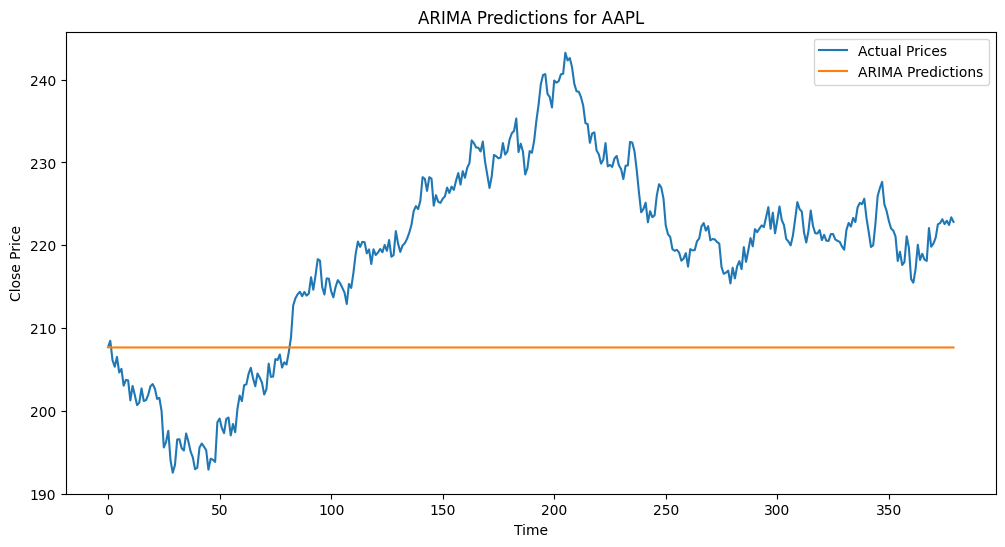

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
LSTM RMSE: 182.42, MAE: 182.06


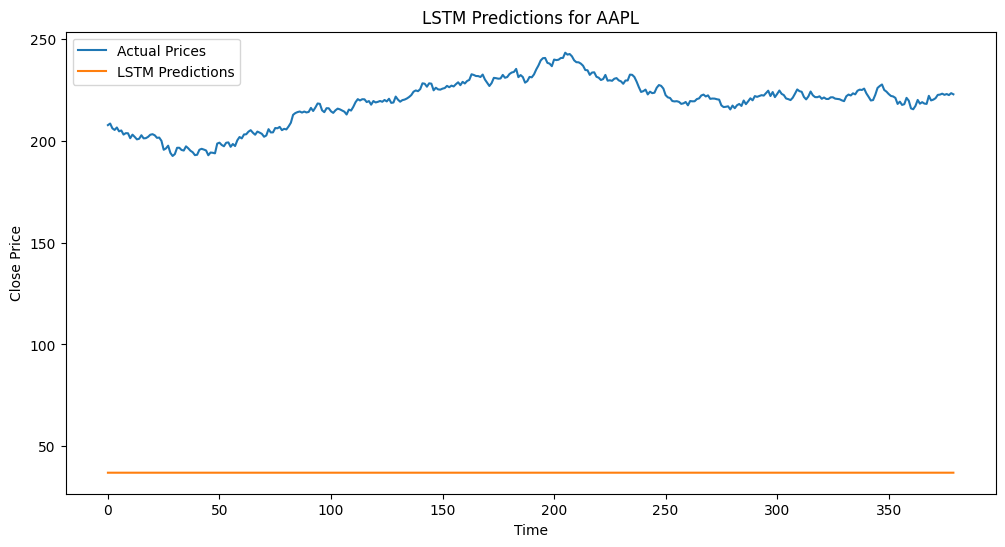

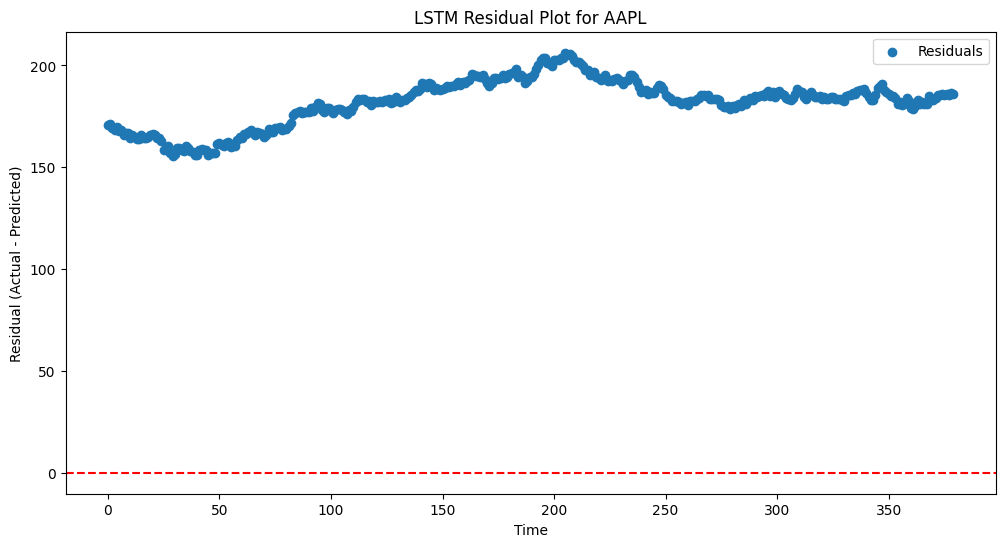

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('stock_data_with_features.csv')
stock_data = data[data['Ticker'] == 'AAPL']
X = stock_data[['MA7', 'MA50', 'Lag1', 'Lag2']]
y = stock_data['Close'].values

# Train-test split
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

# ARIMA Model
arima_model = ARIMA(train, order=(5,1,0)).fit()
arima_pred = arima_model.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
arima_mae = mean_absolute_error(test, arima_pred)
print(f"ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")

# Plot ARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual Prices')
plt.plot(arima_pred, label='ARIMA Predictions')
plt.title('ARIMA Predictions for AAPL')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('arima_predictions.png')
plt.show()

# LSTM Model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_train_reshaped, X_test_reshaped = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(4, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=0)
lstm_pred = model.predict(X_test_reshaped).flatten()
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print(f"LSTM RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")

# Plot LSTM predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(lstm_pred, label='LSTM Predictions')
plt.title('LSTM Predictions for AAPL')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('lstm_predictions.png')
plt.show()

# Residual Plot (LSTM)
residuals = y_test - lstm_pred
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('LSTM Residual Plot for AAPL')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.savefig('lstm_residuals.png')
plt.show()